In [1]:
%reload_ext autoreload
%autoreload 2

In [77]:
import os.path as op
import os

import mne
import hcp
import h5io
import matplotlib.pyplot as plt
import numpy as np
from hcp import io
from hcp import preprocessing as preproc

In [3]:
storage_dir = op.join(op.expanduser('~'),
                      'mne-hcp-data')

hcp_path = op.join(storage_dir, 'HCP')
recordings_path = op.join(storage_dir, 'hcp-meg')
project_path = op.join(storage_dir, 'dynamic-scales')

subject = '105923'
data_type = 'rest'

In [82]:
def _preprocess_raw(raw, hcp_params, ica_sel):
    preproc.apply_ref_correction(raw)

    # construct MNE annotations
    annots = io.read_annot_hcp(**hcp_params)
    bad_seg = (annots['segments']['all']) / raw.info['sfreq']
    annotations = mne.Annotations(
        bad_seg[:, 0], (bad_seg[:, 1] - bad_seg[:, 0]),
        description='bad')

    raw.annotations = annotations
    raw.info['bads'] += annots['channels']['all']
    raw.pick_types(meg=True, ref_meg=False)

    # read ICA and remove EOG ECG or keep brain components
    ica_mat = hcp.io.read_ica_hcp(**hcp_params)
    if ica_sel == 'ecg_eog':
        exclude = annots['ica']['ecg_eog_ic']
    elif ica_sel == 'brain':
        exclude = [ii for ii in range(annots['ica']['total_ic_number'][0])
           if ii not in annots['ica']['brain_ic_vs']]
    preproc.apply_ica_hcp(raw, ica_mat=ica_mat, exclude=exclude)
    # add back missing channels
    raw = preproc.interpolate_missing(raw, **hcp_params)
    return raw


In [83]:
def make_psd_broadband_average(subject, hcp_path, project_path,
                               data_type='rest', run_inds=(0, 1, 2), n_fft=2**15):

    hcp_params = dict(subject=subject, hcp_path=hcp_path,
                  data_type=data_type)

    out_path = op.join(recordings_path, subject)

    for run_index in run_inds:
        hcp_params['run_index'] = run_index
        raw = io.read_raw_hcp(**hcp_params)
        raw.load_data()
    
        raw = _preprocess_raw(raw, hcp_params, ica_sel='brain')
        
        duration = n_fft * (1 / raw.info['sfreq'])
        events = mne.make_fixed_length_events(raw, 42, duration=duration)
        epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0, tmax=duration,
                            baseline=None, preload=False)
        psd, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, fmax=150)
        h5io.write_hdf5(
            op.join(project_path, '{}-psd-broadband-average-run{}.hdf5'.format(
                data_type, run_index)),
            dict(psd=psd.mean(0), freqs=freqs), overwrite=True)

make_psd_broadband_average(subject=subject, hcp_path=hcp_path, project_path=project_path, run_inds=(0,))


Reading 4D PDF file /home/ubuntu/mne-hcp-data/HCP/105923/unprocessed/MEG/3-Restin/4D/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Current compensation grade : 0
Reading 0 ... 749069  =      0.000 ...   368.182 secs...
Reading 4D PDF file /home/ubuntu/mne-hcp-data/HCP/105923/unprocessed/MEG/3-Restin/4D/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Creating RawArray with float64 data, n_chann

In [133]:
psd = psd_dict['psd']

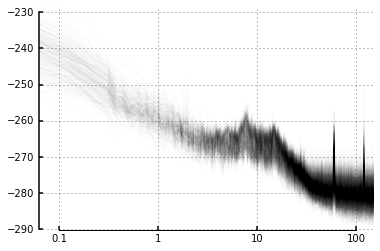

In [134]:
%matplotlib inline
plt.grid(True)
fmask = (freqs >= 0.06) & (freqs <= 150)
psd_ = 10 * np.log10(psd[:, fmask]).T
plt.plot(np.log10(freqs[fmask]), psd_, color='black', alpha=1 / (248 / 3.));
plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])
plt.xlim(np.log10(freqs[fmask][[0, -1]]))
plt.ylim(psd_.min(), psd_.max())

ax = plt.gca()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_bounds(*np.log10([0.1, 100]))
ax.spines['left'].set_bounds(*ax.get_yticks()[1:][:-1][[0, -1]])
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)

In [54]:
raw = mne.io.read_raw_fif(
    op.join(recordings_path, subject, '%s-run%i-preproc-raw.fif' % (data_type, run_index)))
raw.load_data()


Opening raw data file /mnt/hcp-meg/105923/rest-run0-preproc-raw.fif...
Isotrak not found
    Range : 0 ... 749069 =      0.000 ...   368.182 secs
Ready.
Current compensation grade : 0
Annotation expanding outside the data range. Limiting to the end of data.
Reading 0 ... 749069  =      0.000 ...   368.182 secs...


<ipython-input-54-a99193697f41>:2: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  op.join(recordings_path, subject, '%s-run%i-preproc-raw.fif' % (data_type, run_index)))


<Raw  |  rest-run0-preproc-raw.fif, n_channels x n_times : 248 x 749070 (368.2 sec), ~1.38 GB, data loaded>

In [129]:
def make_psd_alpha_epochs(subject, hcp_path, project_path,
                          data_type='rest', run_inds=(0, 1, 2), n_fft=2**13):
    for run_index in run_inds:
        raw = mne.io.read_raw_fif(
            op.join(recordings_path, subject, '%s-run%i-preproc-raw.fif' % (data_type, run_index)))
        raw.load_data()
        raw.interpolate_bads()
        duration = n_fft * (1 / raw.info['sfreq'])
        events = mne.make_fixed_length_events(raw, 42, duration=duration)
        epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0, tmax=duration,
                            baseline=None, preload=True)
        psd, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, fmin=5, fmax=15)
        h5io.write_hdf5(
            op.join(project_path, '{}-psd-alpha-epochs-run{}.hdf5'.format(
                data_type, run_index)),
            dict(psd=psd, freqs=freqs), overwrite=True)

make_psd_alpha_epochs(subject=subject, hcp_path=hcp_path, project_path=project_path)

Opening raw data file /mnt/hcp-meg/105923/rest-run0-preproc-raw.fif...
Isotrak not found
    Range : 0 ... 749069 =      0.000 ...   368.182 secs
Ready.
Current compensation grade : 0
Annotation expanding outside the data range. Limiting to the end of data.
Reading 0 ... 749069  =      0.000 ...   368.182 secs...


<ipython-input-129-27430da8e039>:5: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  op.join(recordings_path, subject, '%s-run%i-preproc-raw.fif' % (data_type, run_index)))


    Computing dot products for 245 coils...
    Computing cross products for coils 245 x 3 coils...
    Preparing the mapping matrix...
    [Truncate at 81 missing 0.0001]
91 matching events found
No baseline correction applied
0 projection items activated
Loading data for 91 events and 8193 original time points ...
23 bad epochs dropped
Effective window size : 4.027 (s)
Opening raw data file /mnt/hcp-meg/105923/rest-run1-preproc-raw.fif...
Isotrak not found
    Range : 0 ... 765715 =      0.000 ...   376.363 secs
Ready.
Current compensation grade : 0
Annotation expanding outside the data range. Limiting to the end of data.
Reading 0 ... 765715  =      0.000 ...   376.363 secs...


<ipython-input-129-27430da8e039>:5: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  op.join(recordings_path, subject, '%s-run%i-preproc-raw.fif' % (data_type, run_index)))


    Computing dot products for 242 coils...
    Computing cross products for coils 242 x 6 coils...
    Preparing the mapping matrix...
    [Truncate at 80 missing 0.0001]
93 matching events found
No baseline correction applied
0 projection items activated
Loading data for 93 events and 8193 original time points ...
32 bad epochs dropped
Effective window size : 4.027 (s)
Opening raw data file /mnt/hcp-meg/105923/rest-run2-preproc-raw.fif...
Isotrak not found
    Range : 0 ... 748663 =      0.000 ...   367.982 secs
Ready.
Current compensation grade : 0
Annotation expanding outside the data range. Limiting to the end of data.
Reading 0 ... 748663  =      0.000 ...   367.982 secs...


<ipython-input-129-27430da8e039>:5: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  op.join(recordings_path, subject, '%s-run%i-preproc-raw.fif' % (data_type, run_index)))


    Computing dot products for 246 coils...
    Computing cross products for coils 246 x 2 coils...
    Preparing the mapping matrix...
    [Truncate at 80 missing 0.0001]
91 matching events found
No baseline correction applied
0 projection items activated
Loading data for 91 events and 8193 original time points ...
23 bad epochs dropped
Effective window size : 4.027 (s)


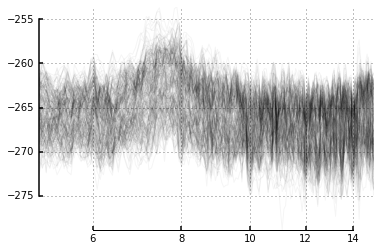

In [121]:
%matplotlib inline
plt.grid(True)
fmask = (freqs >= 5) & (freqs <= 15)
psd_ = 10 * np.log10(psd.mean(0)[:, fmask]).T
plt.plot(np.log10(freqs[fmask]), psd_, color='black', alpha=1 / (248 / 10.));
plt.xticks(np.log10([6, 8, 10, 12, 14]), [6, 8, 10, 12, 14])
plt.xlim(np.log10(freqs[fmask][[0, -1]]))
plt.ylim(psd_.min(), psd_.max())

ax = plt.gca()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_bounds(*ax.get_xticks()[[0, -1]])
ax.spines['left'].set_bounds(*ax.get_yticks()[1:][:-1][[0, -1]])
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)

In [141]:
mne.time_frequency.tfr_morlet?

In [4]:
run_index=1
raw = mne.io.read_raw_fif(
    op.join(recordings_path, subject, '%s-run%i-preproc-raw.fif' % (data_type, run_index)))

raw.load_data()

Opening raw data file /mnt/hcp-meg/105923/rest-run1-preproc-raw.fif...
Isotrak not found
    Range : 0 ... 765715 =      0.000 ...   376.363 secs
Ready.
Current compensation grade : 0
Annotation expanding outside the data range. Limiting to the end of data.
Reading 0 ... 765715  =      0.000 ...   376.363 secs...


<ipython-input-4-bf834e4c0e49>:3: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  op.join(recordings_path, subject, '%s-run%i-preproc-raw.fif' % (data_type, run_index)))


<Raw  |  rest-run1-preproc-raw.fif, n_channels x n_times : 248 x 765716 (376.4 sec), ~1.42 GB, data loaded>

In [5]:
raw.filter(8, None, filter_length='auto', phase='zero', fir_window='hamming', l_trans_bandwidth='auto', h_trans_bandwidth="auto")
raw.filter(None, 12, filter_length='auto', phase='zero', fir_window='hamming', l_trans_bandwidth='auto', h_trans_bandwidth="auto")

High-pass filtering at 8 Hz
l_trans_bandwidth chosen to be 2.0 Hz
Filter length of 6714 samples (3.300 sec) selected
Low-pass filtering at 12 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 4476 samples (2.200 sec) selected


<Raw  |  rest-run1-preproc-raw.fif, n_channels x n_times : 248 x 765716 (376.4 sec), ~1.42 GB, data loaded>

In [6]:
raw_hil = raw.copy()
raw_hil.apply_hilbert(list(range(248)), envelope=True, n_fft='auto')

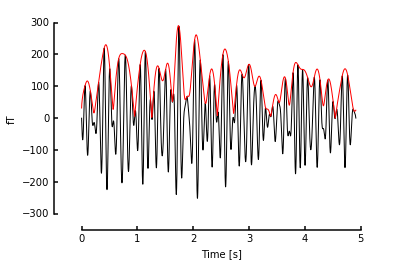

In [53]:
%matplotlib inline
plt.figure()
plt.plot(raw.times[:10000], raw._data[10:11, :10000].T * 1e15, color='black');
plt.plot(raw.times[:10000], raw_hil._data[10:11, :10000].T * 1e15, color='red');
ax = plt.gca()
plt.xlim(-0.5, 5.5)
plt.ylim(-350, 350)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_bounds(0, 5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_bounds(*ax.get_yticks()[1:][:-1][[0, -1]])
ax.spines['left'].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)

plt.xlabel('Time [s]')
plt.ylabel('fT')

In [21]:
psd, freqs = mne.time_frequency.psd_welch(raw_hil, n_fft=2**15)

Effective window size : 16.106 (s)


In [40]:
psd_dict = h5io.read_hdf5(op.join(project_path, '{}-psd-broadband-average-run{}.hdf5'.format('rest', 0)))


In [51]:
import matplotlib
matplotlib.font_manager.fontManager.findfont('Helvetica')

u'/usr/share/fonts/myfonts/Helvetica.ttf'

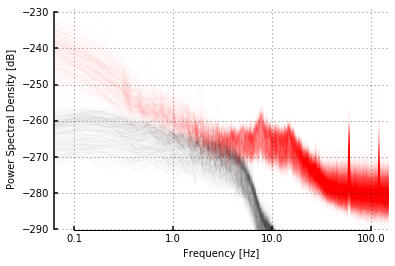

In [52]:
%matplotlib inline
plt.grid(True)

def plot_psd_log(psd, freqs, fmin, fmax, scale_alpha=3, xticks=(0.1, 1, 10, 100),
                 color='black'):
    n_channels = len(psd)
    xticks = np.array(xticks)
    fmask = (freqs >= fmin) & (freqs <= fmax)
    psd_ = 10 * np.log10(psd[:, fmask]).T
    plt.plot(np.log10(freqs[fmask]), psd_, color=color,
                      alpha=1. / (n_channels / scale_alpha));
    plt.xticks(np.log10(xticks), xticks)
    plt.xlim(np.log10(freqs[fmask][[0, -1]]))
    plt.ylim(psd_.min(), psd_.max())

    ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_bounds(*np.log10(xticks[[0, -1]]))
    ax.spines['left'].set_bounds(*ax.get_yticks()[1:][:-1][[0, -1]])
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.xaxis.set_tick_params(width=1.5)
    ax.yaxis.set_tick_params(width=1.5)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power Spectral Density [dB]')
    return plt.gcf()

plot_psd_log(psd, freqs, fmin=.06, fmax=150, scale_alpha=3);

plot_psd_log(psd_dict['psd'], psd_dict['freqs'], fmin=.06, fmax=150, scale_alpha=3, color='red');


In [44]:
raw_hil_z = raw_hil.copy()

In [46]:
from scipy.stats import zscore

In [47]:
raw_hil_z.apply_function(zscore, list(range(248)), dtype=np.float, n_jobs=1)

In [48]:
psd_hil_z, freqs = mne.time_frequency.psd_welch(raw_hil_z, n_fft=2**15)

Effective window size : 16.106 (s)


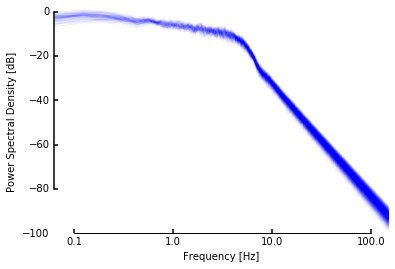

In [49]:
plot_psd_log(psd_hil_z, freqs, fmin=.06, fmax=150, scale_alpha=3, color='blue');


In [63]:
run_index=1
raw_low = mne.io.read_raw_fif(
    op.join(recordings_path, subject, '%s-run%i-preproc-raw.fif' % (data_type, run_index)))

raw_low.load_data()

Opening raw data file /mnt/hcp-meg/105923/rest-run1-preproc-raw.fif...
Isotrak not found
    Range : 0 ... 765715 =      0.000 ...   376.363 secs
Ready.
Current compensation grade : 0
Annotation expanding outside the data range. Limiting to the end of data.
Reading 0 ... 765715  =      0.000 ...   376.363 secs...


<ipython-input-63-fe0812cb2ce7>:3: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  op.join(recordings_path, subject, '%s-run%i-preproc-raw.fif' % (data_type, run_index)))


<Raw  |  rest-run1-preproc-raw.fif, n_channels x n_times : 248 x 765716 (376.4 sec), ~1.42 GB, data loaded>

In [64]:
raw_low.filter(None, 1.3,  filter_length='auto', phase='zero', fir_window='hamming', l_trans_bandwidth='auto', h_trans_bandwidth="auto")
raw_low.apply_hilbert(list(range(248)), envelope=True, n_fft='auto')

Low-pass filtering at 1.3 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 6714 samples (3.300 sec) selected


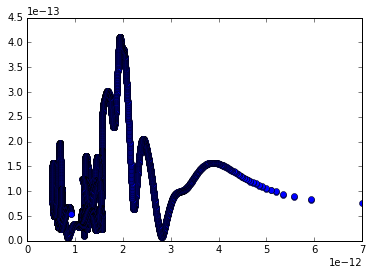

In [66]:
plt.plot(raw_low._data[0, :10000],
         raw_hil._data[0, :10000], marker='o', linestyle='None') 